# NLM Assignment 6
##### Natalie Kim

In [1]:
# Libraries/Packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [4]:
# Read data
eloma = pd.read_csv(r'/Users/xnxk040/Library/CloudStorage/OneDrive-W.WGrainger,inc/Desktop/linear-nonlinear data/myeloma.csv')
eloma.head()

,Time,VStatus,LogBUN,HGB,Platelet,Age,LogWBC,Frac,LogPBM,Protein,SCalc
0,1.25,1,2.2175,9.4,1,67,3.6628,1,1.9542,12,10
1,1.25,1,1.9395,12.0,1,38,3.9868,1,1.9542,20,18
2,2.00,1,1.5185,9.8,1,81,3.8751,1,2.0000,2,15
3,2.00,1,1.7482,11.3,0,75,3.8062,1,1.2553,0,12
4,2.00,1,1.3010,5.1,0,57,3.7243,1,2.0000,3,9


In [7]:
eloma.describe()

,Time,VStatus,LogBUN,HGB,Platelet,Age,LogWBC,Frac,LogPBM,Protein,SCalc
count,65.000000,65.000000,65.00000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000
mean,24.007692,0.738462,1.39290,10.201538,0.861538,60.153846,3.769014,0.753846,1.549660,3.615385,10.123077
std,23.694383,0.442893,0.31263,2.557556,0.348072,10.333850,0.238013,0.434122,0.364206,6.012207,1.815796
min,1.250000,0.000000,0.77820,4.900000,0.000000,38.000000,3.361700,0.000000,0.477100,0.000000,7.000000
25%,7.000000,0.000000,1.14610,8.800000,1.000000,51.000000,3.643500,1.000000,1.361700,0.000000,9.000000
50%,15.000000,1.000000,1.32220,10.200000,1.000000,60.000000,3.732400,1.000000,1.623200,1.000000,10.000000
75%,35.000000,1.000000,1.56820,12.000000,1.000000,67.000000,3.875100,1.000000,1.845100,4.000000,10.000000
max,92.000000,1.000000,2.23550,14.600000,1.000000,82.000000,4.954200,1.000000,2.000000,27.000000,18.000000


In [8]:
eloma.isnull().sum()

Time        0
VStatus     0
LogBUN      0
HGB         0
Platelet    0
Age         0
LogWBC      0
Frac        0
LogPBM      0
Protein     0
SCalc       0
dtype: int64

### About the Data
- `Time`: the survival time in months from diagnosis
- `VStatus`: indicates whether the patient is alive (0) or dead (1) at the end of the study
    - If `Vstatus` is 1, patient died during the study
    - If `Vstatus` is 0, patient was still alive at the end of the study and corresponding value of Time is censored
- `LogBUN`: logarithm of blood urea nitrogen at diagnosis
- `HGB`: hemoglobin at diagnosis
- `Platelet`: platelets at diagnosis (0 = abnormal, 1 = normal)
- `Age`: age at diagnosis, in years
- `LogWBC`: logarithm of the number of white blood cells at diagnosis
- `Frac`: fractures at diangosis: 0 = none, 1 = present
- `LogPBM`: logarithm of the percentage of plasma cells in bone marrow
- `Protein`: proteinuria at diagnosis
- `SCalc`: serum calcium at diagnosis

## Question 1
Identify important prognostic factors from the nine explanatory variables.
1. First include all nine explanatory variables in model
2. After training Proportional Hazard model, retrieve the summary object to obtain test significance values (i.e., p-value) of explanatory variables
3. Look among explanatory variables whose p-values are more than 0.15
4. Remove explanatory variable, if any, that has the highest p-value from the model
5. Repeat Backward steps until there are no more explanatory variables that we can remove

In [11]:
from lifelines import CoxPHFitter
cph = CoxPHFitter()

#### Question 1a
Provide a Step Summary table. Table will show the explanatory variable removed from each step and the variable's test significance value.

In [19]:
variables = ['LogBUN', 'HGB', 'Platelet', 'Age', 'LogWBC',
             'Frac', 'LogPBM', 'Protein', 'SCalc']
step_summary = []
step = 1

In [24]:
while len(variables) > 0:
    cph.fit(eloma[variables + ['Time', 'VStatus']],
            duration_col = 'Time', event_col = 'VStatus')
    summary = cph.summary
    summary['variable'] = summary.index
    removable = summary[summary['p'] > 0.15]
    
    if removable.empty:
        break
    
    big_pval_var = removable['p'].idxmax()
    step_summary.append({'Step': step,
                         'Variable Removed': big_pval_var,
                         'P-Value': removable.loc[big_pval_var, 'p']})
    variables.remove(big_pval_var)
    step += 1
    
step_summary_df = pd.DataFrame(step_summary, )
step_summary_df

,Step,Variable Removed,P-Value
0,1,LogWBC,0.621011
1,2,Protein,0.693410
2,3,Platelet,0.656020
3,4,LogPBM,0.452029
4,5,Frac,0.426168
5,6,Age,0.180759
6,7,SCalc,0.173778


#### Question 1b
Provide table that shows the explanatory variables included in the final model. Besides, show these statistics:
- parameter estimates
- standard errors
- p-values
- hazard ratios
- 95% confidence intervals for the hazard ratios

In [31]:
# Parameter estimates, standard errors, p-values, and CI's
summary = cph.summary

# Hazard ratios
summary['hazard_ratio'] = summary['coef'].apply(np.exp)

# CI for hazard ratios
summary['lower_CI_hr'] = summary['coef lower 95%'].apply(np.exp)
summary['upper_CI_hr'] = summary['coef upper 95%'].apply(np.exp)


In [34]:
# Table of Final Model
final_table = summary[['coef', 'se(coef)', 'p', 'hazard_ratio',
                       'lower_CI_hr', 'upper_CI_hr']]
final_table.columns = ['parameter estimates', 'standard errors',
                       'p-values', 'hazard ratios', 'Lower 95% CI', 'Upper 95% CI']

final_table

,parameter estimates,standard errors,p-values,hazard ratios,Lower 95% CI,Upper 95% CI
covariate,,,,,,
LogBUN,1.715977,0.618553,0.005534,5.562106,1.654725,18.696171
HGB,-0.119663,0.057422,0.037169,0.887219,0.792781,0.992908


#### Question 1c
Plot baseline hazard for final model.

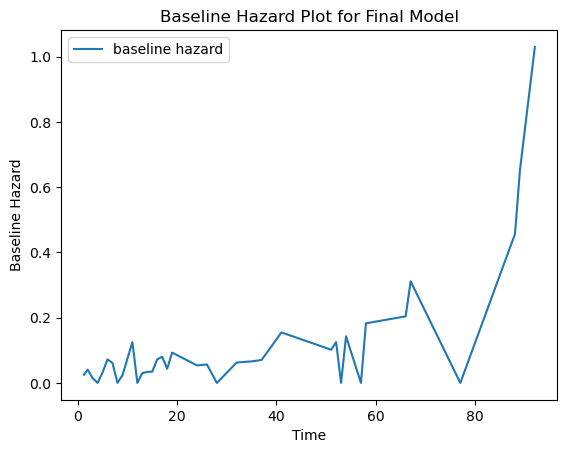

In [35]:
import matplotlib.pyplot as plt

cph.baseline_hazard_.plot()
plt.title('Baseline Hazard Plot for Final Model')
plt.xlabel('Time')
plt.ylabel('Baseline Hazard')
plt.show()

##### What is the chance that individuals will experience an event at time 40 given they survive up to 40?
The plot of the survival function below tells us that at t = 40, the survival rate is approximately 0.30. Since survival probability tells us the chance of *not* experiencing the event by time T, we subtract our estimated survival rate from 1 to get 1 - 0.3 =
**0.7 as the chance that individuals will experience an event.**

<AxesSubplot:>

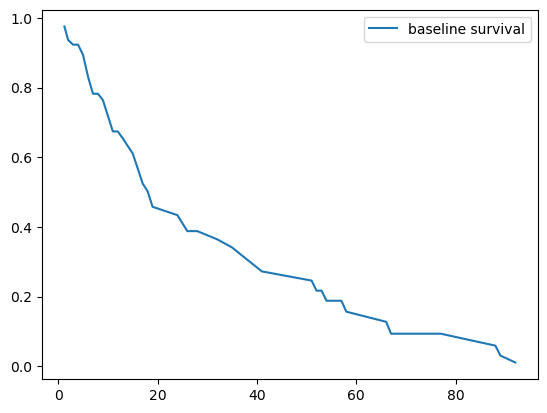

In [36]:
cph.baseline_survival_.plot()

#### Question 1d
Plot LogBUN partial effects with values = [0, 0.5, 1, 1.5, 2]. Remember, with this exercise, we examine what will the survival curve look like as we vary a single covariate while holding everything else equal.

<AxesSubplot:>

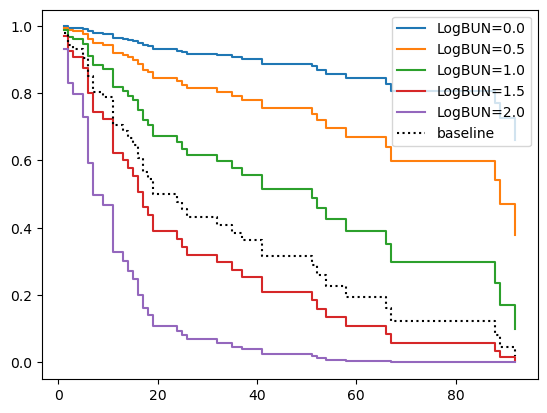

In [50]:
cph.plot_partial_effects_on_outcome(covariates = 'LogBUN', values = [0, 0.5, 1, 1.5, 2])